# **Predicción de sentimientos de Análisis de Reseñas de Libros en Amazon - Utilización, procesamiento y visualización de grandes volúmenes de datos (Portafolio Análisis)**

Gabriela Chimali Nava Ramírez - A01710530



## Introducción

Este proyecto aborda un desafío de Big Data, analizar 3 millones de reseñas de libros de Amazon, un conjunto de datos de más de 2.6 GB. El objetivo principal es construir y evaluar un modelo de Machine Learning capaz de clasificar automáticamente el sentimiento de una reseña como "Positivo" (1.0) o "Negativo" (0.0).

Para manejar este volumen de datos, todo el proceso se realiza con Apache Spark (PySpark). El cuaderno documenta el flujo de trabajo completo:

1. EDA: Pera entender la composición de los archivos de los que se extraerá la información, así como la calidad de los datos para delimitar un alcance con el modelo a desarrollar.

2. ETL: Carga, limpieza y unión de los datos de reseñas y metadatos de los libros.

3. Feature Engineering: Conversión del texto de las reseñas (NLP) y las categorías de los libros en características numéricas que el modelo pueda entender.

4. Modelado: Se entrenan dos modelos, Regresión Logística y Random Forest, para comparar su rendimiento. Utilizando una técnica de ponderación de clases (weightCol) para ayudar al Random Forest a manejar el desbalance entre reseñas positivas y negativas.

5. Evaluación: Se evalúan los modelos usando métricas como Precisión, Recall y F1-Score.

6. Visualización: Se exportan los resultados agregados para su visualización en Tableau.

## 0. Inicializar entorno PySpark y montar Google Drive

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

!pip install pyspark -q
!apt-get update -qq > /dev/null
!apt-get install openjdk-11-jdk -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.12/dist-packages/pyspark"

spark = SparkSession.builder.appName("ProjectBigData1").getOrCreate()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 1. EDA (Análisis Exploratorio de los Datos)

### 1.1. Carga de DataFrames

El análisis utiliza dos archivos del dataset ["Amazon Books Reviews" en Kaggle](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/data):

1. `Books_rating.csv` (2.64 GB): Contiene aproximadamente 3 millones de reseñas. Las columnas clave utilizadas son:
* Title: Título del libro (usado como clave de unión).
* review/score: Calificación numérica (1.0 a 5.0) dada por el usuario.
* review/text: El texto completo de la reseña.

2. `books_data.csv` (455 MB): Contiene metadatos de los libros. Las columnas clave utilizadas son:
* Title: Título del libro (usado como clave de unión).
* categories: Género o categoría del libro.
* authors: Autor(es) del libro.
* publishedDate: Fecha de publicación.

In [3]:
# Rutas a los archivos
ratings_path = "/content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/Books_rating.csv"
metadata_path = "/content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/books_data.csv"

print("\nCargando DataFrames...")
df_ratings_raw = spark.read.csv(
    ratings_path,
    header=True,
    inferSchema=True,
    sep=',',
    multiLine=True,
    escape='"'
)

df_books_raw = spark.read.csv(
    metadata_path,
    header=True,
    inferSchema=True,
    sep=',',
    multiLine=True,
    escape='"'
)

# Seleccionar sólo las columnas necesarias
df_ratings = df_ratings_raw.select(
    col("Title").alias("title"),
    col("review/score").alias("reviewScore"),
    col("review/text").alias("reviewText")
)

df_books = df_books_raw.select(
    col("Title").alias("title"),
    "categories",
    "authors",
    "publishedDate"
)


Cargando DataFrames...


In [4]:
def file_size(file_path):
    size_bytes = os.path.getsize(file_path)
    size_gb = size_bytes / (1024 * 1024 * 1024)
    return size_gb

print(f"Reseñas cargadas: {df_ratings_raw.count()}")
print(f"Tamaño del archivo de reseñas: {file_size(ratings_path):.2f} GB")
print(f"Datos de los libros cargados: {df_books_raw.count()}")
print(f"Tamaño del archivo de datos de libros: {file_size(metadata_path):.2f} GB")

Reseñas cargadas: 3000000
Tamaño del archivo de reseñas: 2.66 GB
Datos de los libros cargados: 212404
Tamaño del archivo de datos de libros: 0.17 GB


### 1.2. Exportación de muestra para Análisis con Tableau

Se exportan sólo los datos de las columnas relevantes para este proyecto seleccionadas previamente.

Dada la cantidad limitada de datos que pueden cargarse en Tableau, para el archivo `Book_rating.csv` se selecciona una muestra del 30% de las filas totales y `books_data.csv` se exporatan todos los registros.

Dado que varias columnas textuales del dataset contienen comas, comillas y otros delimitadores internos, el uso de archivos CSV tradicionales daba problemas al cargarlos en Tableau, produciendo la separación incorrecta de columnas. Para asegurar una importación limpia, los archivos se exportan utilizando delimitación mediante tabulaciones (TSV, Tab-Separated Values). Un formato más robusto para datos textuales extensos y que permite que Tableau identifique correctamente la estructura del archivo.

In [ ]:
path_ratings_eda = "/content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/eda_ratings_sample.csv"

df_ratings.sample(False, 0.3, seed=42) \
    .coalesce(1) \
    .write.option("delimiter", "\t") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .csv(path_ratings_eda, header=True, mode="overwrite")

path_books_eda = "/content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/eda_books.csv"

df_books.coalesce(1) \
    .write.option("delimiter", "\t") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .csv(path_books_eda, header=True, mode="overwrite")

### 1.3 EDA del archivo de "books"

Disponible online en [Tableau Public](https://public.tableau.com/views/EDABooks/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link).

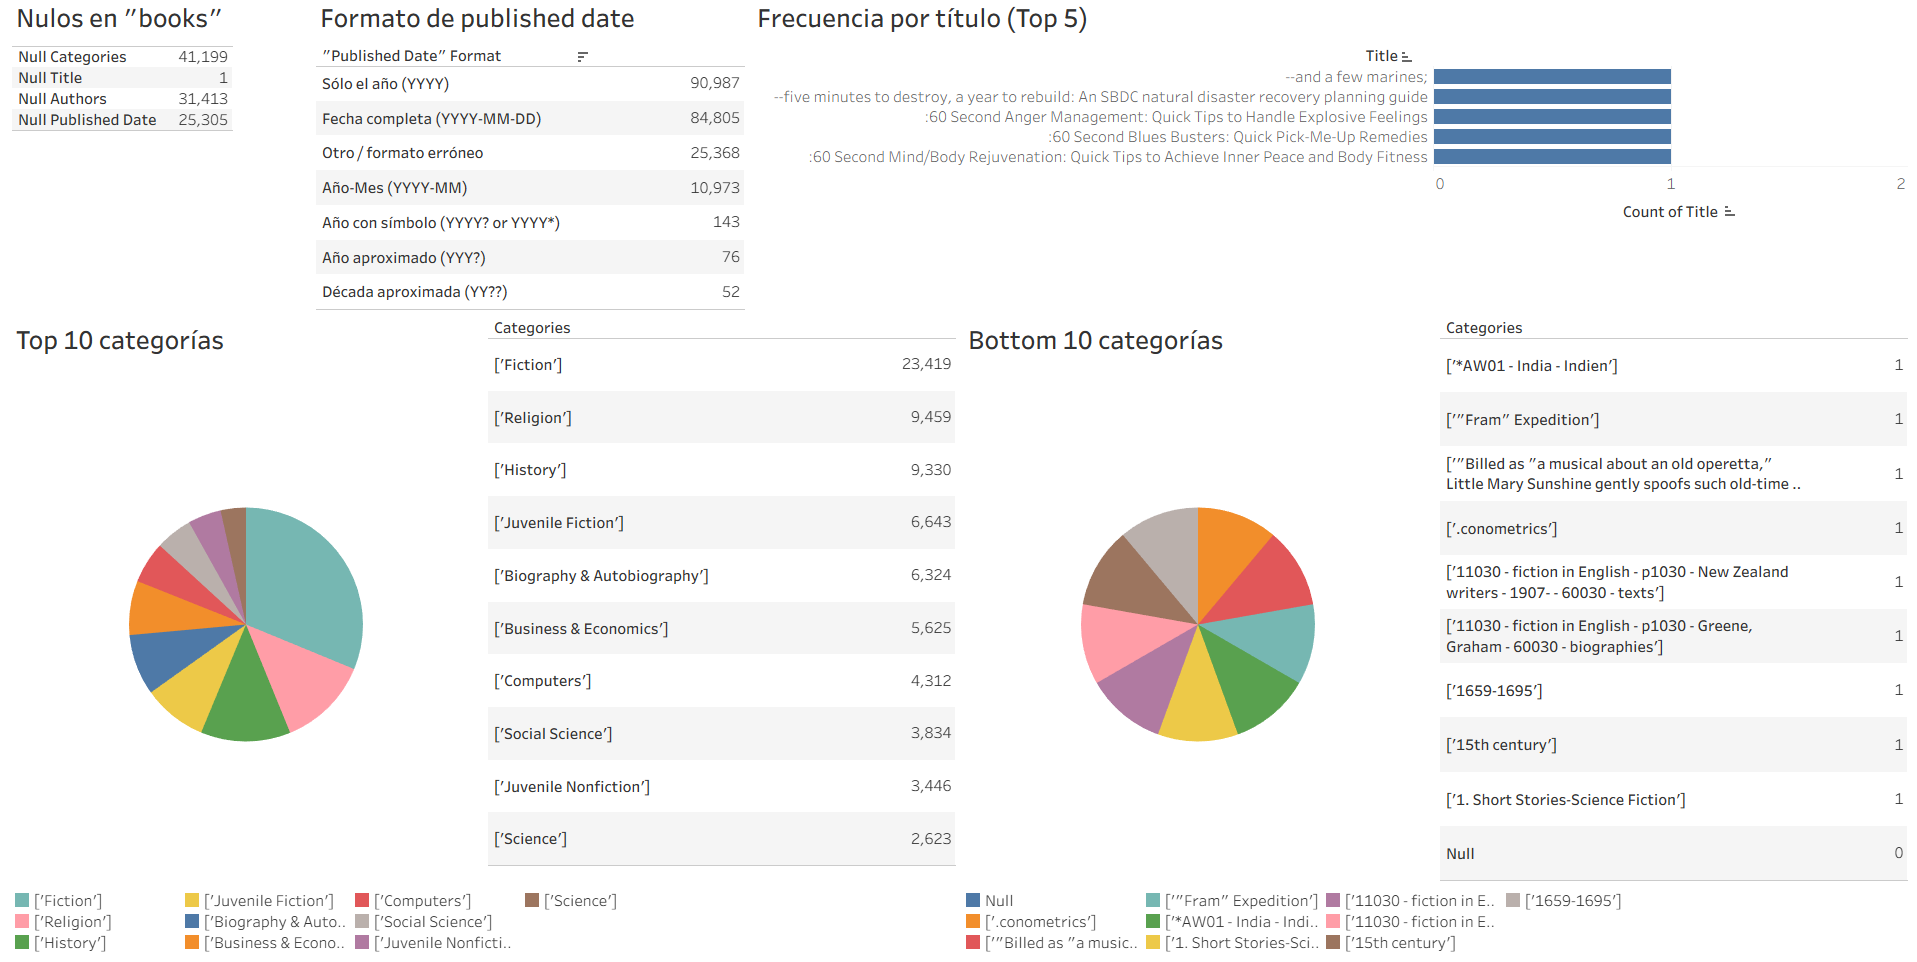

**1. Valores nulos**
* Categories y Authors tienen tantos nulos que eliminarlos distorsionaría el dataset así que deben imputarse. Se optó por colocarles la etiqueta "Desconocido”.
* PublishedDate también tiene varios registros nulos (~12%) no es usable directamente, así que requiere transformación.

**2. Formatos de Published Date**
* La mayoría de registros correctos con los que se cuenta (~43%) son sólo el año de publicación por loque se opta por extraer sólo el año.

* Los casos aproximados como 19?? o 184? se imputarán con 0.

**3. Top 5 títulos con mayor frecuencia"**: En su formato actual no se cuenta con duplicados, esto se deduce dado que se filtraron los títulos desde aquellos que más se repiten y su valor fue 1. Sin embargo, tras eliminar caracteres especiales se debe validar este punto nuevamente.

**4. Categorías Top y Bottom 10**:
* Hay una alta concentración en pocas categorías y hay varias extremadamente raras y poco representativas en el dataset.
* Hay categorías con símbolos (“['*AW01 - India - Indien']”) que podrían ser datos mal formados o listados extensos. Debido a estas inconsisntencias se requiere limpieza de los *strings*.

### 1.4. EDA del archivo de "ratings"

Disponible online en [Tableau Public](https://public.tableau.com/views/EDARatings/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link).

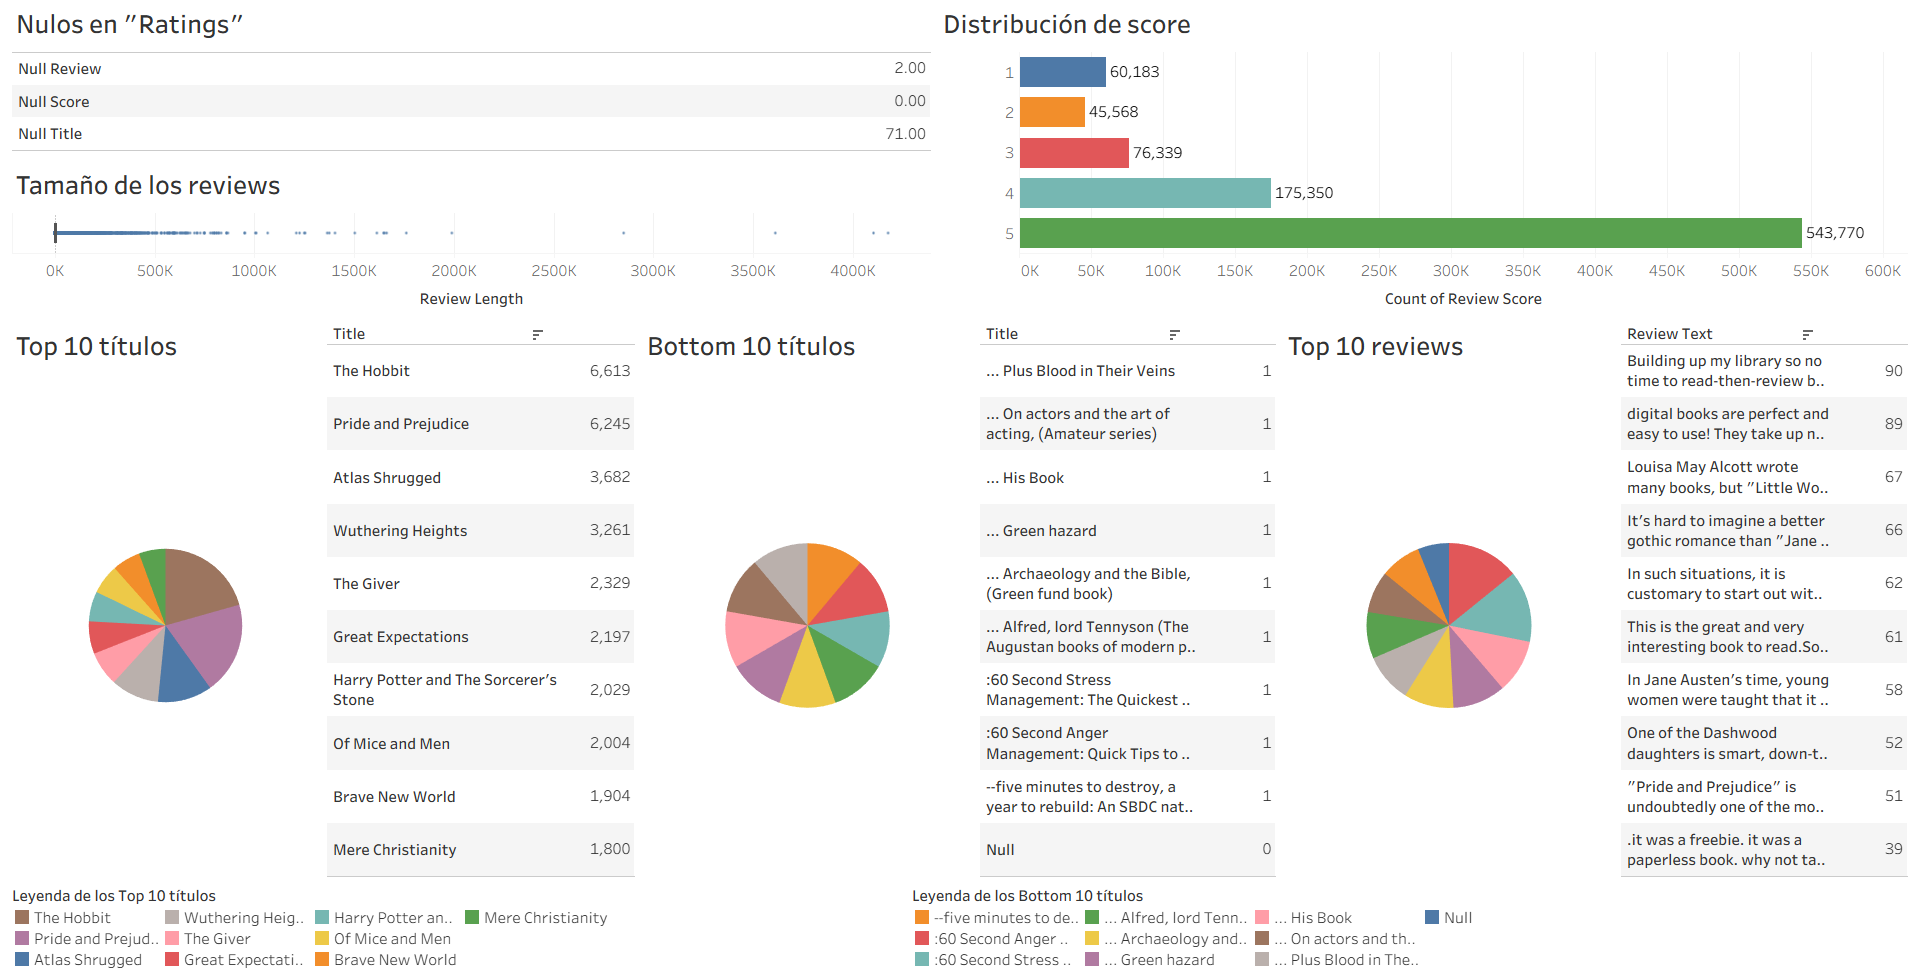

**1. Valores nulos**
 * Los textos vacíos no aportan información al análisis de sentimiento así que deben eliminarse.

* Existen 71 títulos nulos significa que la reseña no puede asociarse a ningún libro así que también deben eliminarse antes del *join*.

**2. Longitud de las reseñas**
* Es extremadamente variable desde pocos caracteres hasta más de 4 millones. Estos *outliers* muy largos probablemente sean ruido o errores de escritura con caracteres especiales.

* Esto confirma que el texto requiere normalización y el uso de *HashingTF* para evitar que esta variabilidad afecte el modelo.

**3. Distribución del "score"**
* El *dataset* está fuertemente desbalanceado hacia reseñas positivas, lo que podría influir en la detección pobre de las reseñas negativas.

* Se eliminará la clase 3 (neutral) porque está subrepresentada y no aporta información al clasificador binario.

**4. Top 10 títulos**: Existe un alto nivel de concentración en libros clásicos y populares. Probablemente tendrán influencia dominante en el modelo.

**5. Bottom 10 títulos**: Gran parte de los libros tienen una sola reseña, esto significa una "cola larga". Por lo tanto refuerza la necesidad de seleccionar sólo categorías representatitvas tras el *join*.

**6. Top 10 review texts**: Hay muchas reseñas repetidas que pueden indicar duplicados o reseñas spam. También deben identificarse y eliminarse.

## 2. ETL inicial de los datos

### 2.1. Limpieza de los datos para el JOIN

Acorde con el EDA anterior se procede a:
* **Eliminar** (`dropna`) las filas si las columnas críticas son nulas.
    * Para ratings: `["title", "reviewScore", "reviewText"]`
    * Para books: `["title"]`

* **Imputar** (`fillna`) los nulos de columnas de books `["categories", "authors"]` con el valor `"Desconocido"`. De esta forma podríamos tratar este valor como una categoría en sí.

* Para `["publicationDate"]` se imputa `0`.

In [5]:
# Eliminar filas de ratings
columnas_criticas_ratings = ["title", "reviewScore", "reviewText"]
df_ratings_clean = df_ratings.dropna(subset=columnas_criticas_ratings)

# Eliminar filas de books si "Title" es nulo
df_books_clean = df_books.dropna(subset=["title"])

# Imputar features nulos en books
columnas_imputar = ["categories", "authors"]
df_books_clean = df_books_clean.fillna("Desconocido", subset=columnas_imputar)

# Obtener sólo el año o imputar con 0
df_books_clean = df_books_clean.withColumn(
    "publicationYear",
    # Año completo válido
    when(substring(col("publishedDate"), 1, 4).rlike(r'^\d{4}$'),
         substring(col("publishedDate"), 1, 4))
    # 187? -> 1870
    .when(substring(col("publishedDate"), 1, 4).rlike(r'^\d{3}\?$'),
         concat(substring(col("publishedDate"), 1, 3), lit("0")))
    # 18?? -> 1800
    .when(substring(col("publishedDate"), 1, 4).rlike(r'^\d{2}\?\?$'),
         concat(substring(col("publishedDate"), 1, 2), lit("00")))
    # Cualquier otro caso erróneo
    .otherwise("0")
    .cast(IntegerType())
)

df_books_clean = df_books_clean.drop("publishedDate")

print(f"Reseñas después de limpieza: {df_ratings_clean.count()}")
print(f"Books después de limpieza: {df_books_clean.count()}")

Reseñas después de limpieza: 2999784
Books después de limpieza: 212403


In [6]:
df_books_clean.show(10)

+--------------------+--------------------+--------------------+---------------+
|               title|          categories|             authors|publicationYear|
+--------------------+--------------------+--------------------+---------------+
|Its Only Art If I...|['Comics & Graphi...|    ['Julie Strain']|           1996|
|Dr. Seuss: Americ...|['Biography & Aut...|      ['Philip Nel']|           2005|
|Wonderful Worship...|        ['Religion']|    ['David R. Ray']|           2000|
|Whispers of the W...|         ['Fiction']| ['Veronica Haddon']|           2005|
|Nation Dance: Rel...|         Desconocido|     ['Edward Long']|           2003|
|The Church of Chr...|        ['Religion']|['Everett Ferguson']|           1996|
|The Overbury affa...|         Desconocido|['Miriam Allen De...|           1960|
|A Walk in the Woo...|         Desconocido|    ['Lee Blessing']|           1988|
|Saint Hyacinth of...|['Biography & Aut...|['Mary Fabyan Win...|           2009|
|Rising Sons and D...|  ['So

### 2.2. Limpieza de cadenas de texto

Se aplica `lower, trim y regexp_replace` a la columna `["title"]` en ambos *DataFrames* para estandarizar la clave de unión. Sin esta normalización, un mismo libro con variaciones en la escritura del título no coincidiría. Por ejemplo: "mi libro", "Mi Libro.", etcétera; resultando en un *join* fallido y pérdida de datos.

También se **eliminan** los caracteres especiales de las columnas `["category"] y ["authors"]` y se **queda** sólo la/el primer nombre registrado en la fila, asumiendo que es lo más relevante. Ya que, manejar listas múltiples requeriría técnicas más complejas como multi-hot encoding, lo cual incrementaría la dimensionalidad y costo computacional.

In [7]:
df_books_clean = df_books_clean.withColumn(
    "title",
    trim(regexp_replace(lower(col("title")), r"[^a-z0-9\s]", ""))
)

df_ratings_clean = df_ratings_clean.withColumn(
    "title",
    trim(regexp_replace(lower(col("title")), r"[^a-z0-9\s]", ""))
)

# Limpiar y obtener la primera categoría
df_books_clean = df_books_clean.withColumn("categories",
    regexp_replace(col("categories"), r"[\'\[\]]", "")
)
df_books_clean = df_books_clean.withColumn("categories",
    split(col("categories"), ",")[0]
)

# Limpiar y obtener el primer autor
df_books_clean = df_books_clean.withColumn("authors",
    regexp_replace(col("authors"), r"[\'\[\]]", "")
)
df_books_clean = df_books_clean.withColumn("authors",
    split(col("authors"), ",")[0]
)

In [8]:
df_books_clean.show(10)
df_ratings_clean.show(10)

+--------------------+--------------------+--------------------+---------------+
|               title|          categories|             authors|publicationYear|
+--------------------+--------------------+--------------------+---------------+
|its only art if i...|Comics & Graphic ...|        Julie Strain|           1996|
|dr seuss american...|Biography & Autob...|          Philip Nel|           2005|
|wonderful worship...|            Religion|        David R. Ray|           2000|
|whispers of the w...|             Fiction|     Veronica Haddon|           2005|
|nation dance reli...|         Desconocido|         Edward Long|           2003|
|the church of chr...|            Religion|    Everett Ferguson|           1996|
|the overbury affa...|         Desconocido|Miriam Allen De Ford|           1960|
|a walk in the woo...|         Desconocido|        Lee Blessing|           1988|
|saint hyacinth of...|Biography & Autob...|Mary Fabyan Windeatt|           2009|
|rising sons and d...|      

### 2.3. JOIN de los DataFrames

Durante la primer ejecución del *join* aumentó la cantidad de registros de reseñas, por lo que se dedujo un dupliado de títulos tras la primer limpieza de la columna `title` en el archivo `books`. Así que nuevamente se analizó la frecuencia de esta columna y se encontraron títulos duplicados que igualmente duplican las reseñas. Estos deben **eliminarse** para evitar generar ambigüedad.

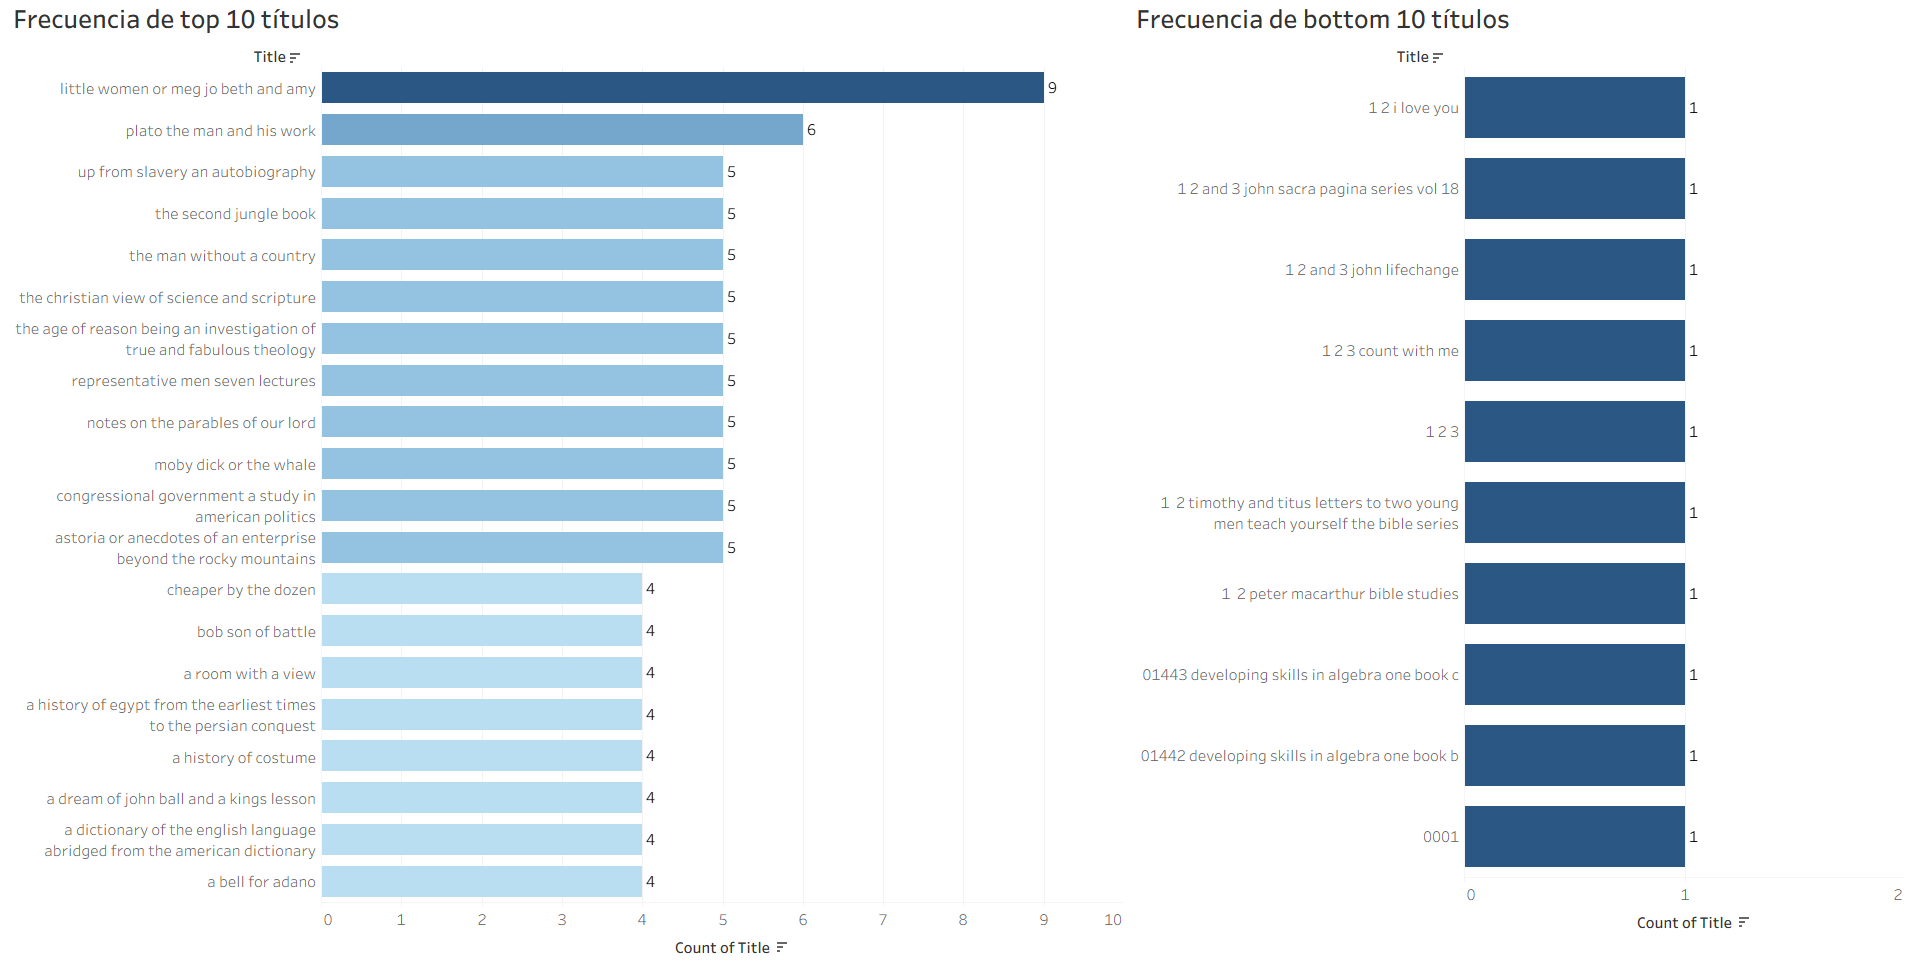

In [15]:
original_books_size = df_books_clean.count()

In [16]:
df_books_clean = df_books_clean.dropDuplicates(["title"])

clean_books_size = df_books_clean.count()
print(f"Books después de borrar duplicados: {clean_books_size}")
print(f"Se eliminaron: {original_books_size - clean_books_size} registros ")

Books después de borrar duplicados: 207065
Se eliminaron: 5338 registros 


In [17]:
df_join = df_ratings_clean.join(
    df_books_clean,
    on="title",
    how="left"
)

Verificación final de eliminación de todos los registros nulos.

In [18]:
print("Registros nulos en df_join:")
df_join.select([
    count(when(isnull(col) | isnan(col), col)).alias(col)
    for col in df_join.columns
]).show()

print(f"Reseñas después del join: {df_join.count()}")

Registros nulos en df_join:
+-----+-----------+----------+----------+-------+---------------+
|title|reviewScore|reviewText|categories|authors|publicationYear|
+-----+-----------+----------+----------+-------+---------------+
|    0|          0|         0|         0|      0|              0|
+-----+-----------+----------+----------+-------+---------------+

Reseñas después del join: 2999784


### 2.4. Creación de la Etiqueta Binaria para el modelo

El objetivo es un modelo de sentimiento (Positivo/Negativo). Así que usando la columna `["reviewScore"]` se genera una etiqueta binaria:
* Las reseñas de 4.0 y 5.0 = `1.0` (Positivo).
* Las reseñas de 1.0 y 2.0 = `0.0` (Negativo).

Como se mencionó en el EDA, **eliminan** las reseñas de 3.0 estrellas. Ya que no representan gran porcentaje del total de registros y pueden ser ambiguas, neutrales o mixtas ("El libro es bueno, pero el envío fue malo"). Incluirlas podría dificultar al modelo aprender la diferencia clara entre positivo y negativo.

In [19]:
df_labeled = df_join.withColumn("label",
    when(col("reviewScore") >= 4.0, 1.0)
    .when(col("reviewScore") <= 2.0, 0.0)
    .otherwise(None)
)

df_model_data = df_labeled.dropna(subset=["label"])
print(f"Filas para el modelo (sin 3 estrellas): {df_model_data.count()}")


Filas para el modelo (sin 3 estrellas): 2745497


In [20]:
df_complete = df_model_data.select(
    "label",
    "reviewText",
    col ("categories").alias ("category"),
    col("authors").alias ("first_author"),
    "publicationYear"
)

df_complete_clean = df_complete.dropna()

print(f">> Total de filas con strings limpios: {df_complete_clean.count()}")

>> Total de filas con strings limpios: 2745497


### 2.5. Seleccionar sólo las categorías más representativas

Se conservan únicamente las categorías que representan más del **1% del total de reseñas**, las más significativas. Como se observó en el EDA, hay categorías con muy pocas muestras que actúan como ruido. El modelo tendría dificultades para aprender patrones de categorías que aparecen unas pocas veces, y esto podría llevar a *overfitting*.

1. Calcular cantidad de reseñas.
2. Calcular cantidad de reseñas por categoría y su equivalencia en porcentaje respecto al total.
3. Seleccionar sólo las categorías que representan más del 1% del total.

Al final resulta en un archivo de `1.53 GB`.

In [21]:
total_reviews = df_complete_clean.count()

df_category_counts = df_complete_clean.groupBy("category").count()
df_category_counts = df_category_counts.withColumn(
    "percentage",
    (col("count") / total_reviews) * 100
)

categories_to_keep = [row["category"] for row in df_category_counts.filter(col("percentage") > 1).collect()]

print("Categorías que representan más del 1% del total de reseñas:")
print(categories_to_keep)

df_filtered = df_complete_clean.filter(col("category").isin(categories_to_keep))

print(f"\n>> Filas después de filtrar por categorías (> 1%): {df_filtered.count()}")

Categorías que representan más del 1% del total de reseñas:
['Computers', 'Social Science', 'Biography & Autobiography', 'Business & Economics', 'Religion', 'Fiction', 'History', 'Juvenile Nonfiction', 'Self-Help', 'Juvenile Fiction', 'Desconocido', 'Cooking']

>> Filas después de filtrar por categorías (> 1%): 1922939


El paso final del ETL es guardar el *DataFrame* limpio como un archivo CSV en *Google Drive*. Para preservar los datos para su uso posterior sin la necesidad de ejecutar nuevamente todo el cóigo anterior.

In [22]:
path_clean = "/content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/df_clean"
df_filtered.coalesce(1).write.csv(path_clean, header=True, mode="overwrite")
print(f"Archivo limpio guardado en: {path_clean}")

Archivo limpio guardado en: /content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/df_clean


## 3. Feature Engineering

### 3.1. Importar librerías y división de datos

Separar los conjuntos de entrenamiento (80%) y prueba (20%).

Se guardarán en el caché (memoria) para un acceso más rápido. Esto evita recálculos repetitivos de Spark pues este, cada vez que se usa un DataFrame, recalcularía toda su ascendencia.

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF,
    StringIndexer, OneHotEncoder, VectorAssembler
)

(train, test) = df_filtered.randomSplit([0.8, 0.2], seed=42)
train.cache()
test.cache()

DataFrame[label: double, reviewText: string, category: string, first_author: string, publicationYear: int]

### 3.2. Procesamiento de Texto (NLP)

* Tokenizar: Separar el texto en palabras.

* StopWordsRemover: Eliminar palabras comunes que no aportan al modelo. Como "el", "la", "y".

* HashingTF: Convertir las palabras en un vector de números de longitud fija que no depende del tañaño del vocabulario. Por lo que es más estable ante textos largos.

In [24]:
tokenizer_text = Tokenizer(inputCol="reviewText", outputCol="words_text")
stopwords_text = StopWordsRemover(inputCol="words_text", outputCol="filtered_text")
hashingtf_text = HashingTF(inputCol="filtered_text", outputCol="features_text", numFeatures=1000)

### 3.3. Procesamiento de variables categóricas

* StringIndexer: Convierte las categorías en un número.

* OneHotEncoder: Convierte en un vector de 1's y 0's los índices anteriores.

Esto es importante porque permite que el modelo considere tanto la información del contenido textual como la metadata del libro.

In [25]:
index_category = StringIndexer(inputCol="category", outputCol="category_index", handleInvalid="keep")
ohe_category = OneHotEncoder(inputCol="category_index", outputCol="category_vec")

### 3.4. Ensamblar todas las features

Combinación de las columnas en un sólo vector de características que un modelo de machine learning puede procesar. Esto es requerido por los algoritmos de *PySpark ML*.

In [26]:
assembler = VectorAssembler(
    inputCols=[
        "features_text",
        "category_vec",
        "publicationYear"
    ],
    outputCol="features"
)

## 4. Modelado

### 4.1. Definir modelo y pipelines

Se implementan dos modelos de clasificación para comparar su desempeño:

1. **Regresión Logística**: Servirá como punto de referencia. Es simple y rápido de entrenar, pero no incluye manejo especial para el desbalance de clases.

2. **Random Forest**: Un modelo más robusto que utiliza un conjunto de árboles de decisión. Para manejar el desbalance significativo en los datos, se implementa una estrategia de pesos de clase (`class_weights`), dando **6 veces más importancia a las reseñas negativas** (clase minoritaria).

Los modelos se integran en pipelines completos que incluyen todo el preprocesamiento necesario. Para garantizar que tanto los datos de entrenamiento como los de prueba pasen por las mismas transformaciones.

In [27]:
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier
)
from pyspark.sql.functions import col, when

# Modelo 1: Regresión Logística
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Modelo 2: Random Forest
class_weights = {1.0: 1.0, 0.0: 6.0}

# Agregar columna de "weight" al DataFrame
df_weighted = df_filtered.withColumn("weight", when(col("label") == 1.0, class_weights[1.0]).otherwise(class_weights[0.0]))

# Separación de conjuntos
(train_weighted, test_weighted) = df_weighted.randomSplit([0.8, 0.2], seed=42)
train_weighted.cache()
test_weighted.cache()

rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42, weightCol="weight")

# --- Pipeline 1: Con Regresión Logística ---
pipeline_lr = Pipeline(stages=[
    tokenizer_text, stopwords_text, hashingtf_text,
    index_category, ohe_category,
    assembler,
    lr
])

# --- Pipeline 2: Con Random Forest ---
pipeline_rf = Pipeline(stages=[
    tokenizer_text, stopwords_text, hashingtf_text,
    index_category, ohe_category,
    assembler,
    rf
])

### 4.2. Entrenamiento de los modelos

In [28]:
print("Entrenando Modelo 1: Regresión Lineal")
model_lr = pipeline_lr.fit(train)

Entrenando Modelo 1: Regresión Lineal


In [29]:
print("\nEntrenando Modelo 2: Random Forest")
model_rf = pipeline_rf.fit(train_weighted)


Entrenando Modelo 2: Random Forest


### 4.3. Generar predicciones

In [30]:
print("Predicciones Modelo 1: Regresión Logística")
predictions_lr = model_lr.transform(test)
print("Predicciones Modelo 2: Random Forest")
predictions_rf = model_rf.transform(test_weighted)

Predicciones Modelo 1: Regresión Logística
Predicciones Modelo 2: Random Forest


## 5. Evaluación de los modelos

In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, sum, when

print(">> Evaluación Regresión Logística")
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

acc_lr = evaluator.setMetricName("accuracy").evaluate(predictions_lr)
print(f"Accuracy (LR): {acc_lr:.4f}")

f1_lr = evaluator.setMetricName("f1").evaluate(predictions_lr)
print(f"F1-Score (LR): {f1_lr:.4f}")

prec_lr_0 = evaluator.setMetricName("precisionByLabel").setMetricLabel(0.0).evaluate(predictions_lr)
print(f"Precision Negativos (LR): {prec_lr_0:.4f}")

prec_lr_1 = evaluator.setMetricName("precisionByLabel").setMetricLabel(1.0).evaluate(predictions_lr)
print(f"Precision Positivos (LR): {prec_lr_1:.4f}")

print("\nMatriz de Confusión (LR):")
confusion_matrix_lr = predictions_lr.groupBy("label", "prediction").count().orderBy("label", "prediction")
confusion_matrix_lr.show()

print("\n>> Evaluación Random Forest")

acc_rf = evaluator.setMetricName("accuracy").evaluate(predictions_rf)
print(f"Accuracy (RF): {acc_rf:.4f}")

f1_rf = evaluator.setMetricName("f1").evaluate(predictions_rf)
print(f"F1-Score (RF): {f1_rf:.4f}")

prec_rf_0 = evaluator.setMetricName("precisionByLabel").setMetricLabel(0.0).evaluate(predictions_rf)
print(f"Precision Negativos (RF): {prec_rf_0:.4f}")

prec_rf_1 = evaluator.setMetricName("precisionByLabel").setMetricLabel(1.0).evaluate(predictions_rf)
print(f"Precision Positivos (RF): {prec_rf_1:.4f}")

print("\nMatriz de Confusión (RF):")
confusion_matrix_rf = predictions_rf.groupBy("label", "prediction").count().orderBy("label", "prediction")
confusion_matrix_rf.show()

>> Evaluación Regresión Logística
Accuracy (LR): 0.8814
F1-Score (LR): 0.8525
Precision Negativos (LR): 0.6397
Precision Positivos (LR): 0.8912

Matriz de Confusión (LR):
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|  9625|
|  0.0|       1.0| 40234|
|  1.0|       0.0|  5420|
|  1.0|       1.0|329689|
+-----+----------+------+


>> Evaluación Random Forest
Accuracy (RF): 0.8350
F1-Score (RF): 0.8301
Precision Negativos (RF): 0.3426
Precision Positivos (RF): 0.8975

Matriz de Confusión (RF):
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0| 14864|
|  0.0|       1.0| 34995|
|  1.0|       0.0| 28525|
|  1.0|       1.0|306584|
+-----+----------+------+



## 6. Visualización

### 6.1. Exportación de datos

In [32]:
def aggregate_model_performance(predictions_df, model_name, group_by_col):

    df_agg = predictions_df.groupBy(group_by_col) \
        .agg(
            count("*").alias("total_de_reseñas"),
            sum(when((col("label") == 0.0) & (col("prediction") == 0.0), 1).otherwise(0)).alias("VN"),
            sum(when((col("label") == 1.0) & (col("prediction") == 0.0), 1).otherwise(0)).alias("FN"),
            sum(when((col("label") == 0.0) & (col("prediction") == 1.0), 1).otherwise(0)).alias("FP"),
            sum(when((col("label") == 1.0) & (col("prediction") == 1.0), 1).otherwise(0)).alias("VP")
        ) \
        .withColumn("modelo", lit(model_name))

    return df_agg

agg_lr_cat = aggregate_model_performance(predictions_lr, "Regresión Logística", "category")
agg_rf_cat = aggregate_model_performance(predictions_rf, "Random Forest", "category")

df_comparacion_categoria = agg_lr_cat.union(agg_rf_cat)

agg_lr_auth = aggregate_model_performance(predictions_lr, "Regresión Logística", "first_author")
agg_rf_auth = aggregate_model_performance(predictions_rf, "Random Forest", "first_author")

df_comparacion_autor = agg_lr_auth.union(agg_rf_auth)

print("Exportando CSVs para Tableau...")
path_cat = "/content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/tableau_category.csv"
path_auth = "/content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/tableau_author.csv"

# Exportar directamente a CSV usando PySpark
df_comparacion_categoria.coalesce(1).write.csv(path_cat, header=True, mode="overwrite")
print(f"Archivo de Categorías guardado en: {path_cat}")

df_comparacion_autor.coalesce(1).write.csv(path_auth, header=True, mode="overwrite")
print(f"Archivo de Autores guardado en: {path_auth}")

Exportando CSVs para Tableau...
Archivo de Categorías guardado en: /content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/tableau_category.csv
Archivo de Autores guardado en: /content/gdrive/MyDrive/AI_data_set/AmazonBooksReviews/tableau_author.csv


## 7. Conclusiones


## 8. Referencias

1.  Bekheet, M. (2022, septiembre 13). *Amazon Books Reviews*. https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/data
2. Sharma, S. (2023, diciembre 28). *Amazon Books Review (EDA + Sentiment-Analysis)*. https://www.kaggle.com/code/shubham2703/amazon-books-review-eda-sentiment-analysis

